In [1]:
import paho.mqtt
import pandas as pd
import paho.mqtt.subscribe as subscribe
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics import tsaplots
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import pickle

In [149]:
env = pd.read_json("enviornment_data.json")
env["timestamp"] = pd.to_datetime(env["timestamp"], unit="ms")
env.set_index('timestamp',inplace=True)
df_res = env.resample("10min").last()

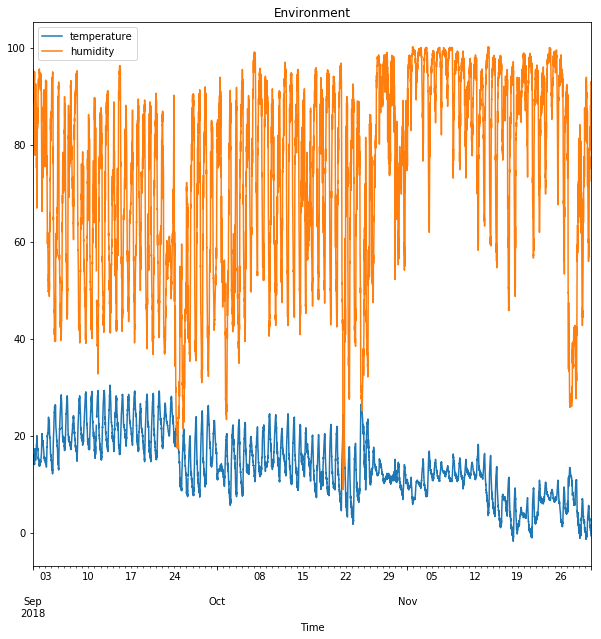

In [151]:
df_res[["temperature", "humidity"]].plot(title="Environment",figsize=(10, 10))
plt.xlabel("Time")
plt.show()

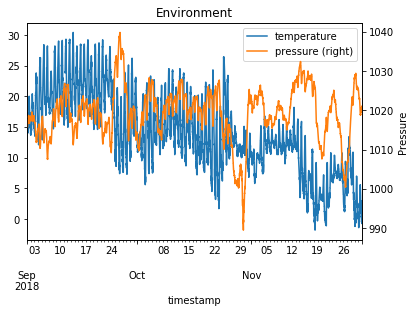

In [152]:
df_res[["temperature", "pressure"]].plot(title="Environment", secondary_y="pressure")
plt.ylabel('Temperature')
plt.ylabel('Pressure')
plt.show()

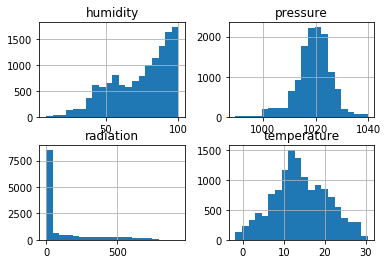

In [153]:
df_res[['humidity','pressure','radiation','temperature']].hist(bins=20)
plt.show()

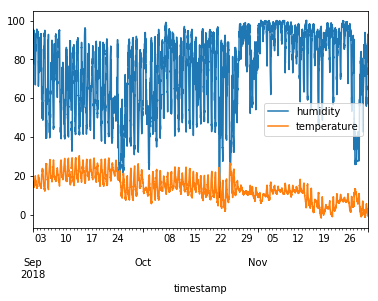

In [154]:
df_res[['humidity','temperature']].plot()

In [155]:
df_res.corr()

,humidity,precipitation,pressure,radiation,sunshine,temperature
humidity,1.000000,0.133335,-0.012779,-0.583625,-0.511791,-0.631426
precipitation,0.133335,1.000000,-0.270549,-0.072305,-0.049957,-0.048759
pressure,-0.012779,-0.270549,1.000000,0.025657,0.012162,-0.138054
radiation,-0.583625,-0.072305,0.025657,1.000000,0.743849,0.514957
sunshine,-0.511791,-0.049957,0.012162,0.743849,1.000000,0.534758
temperature,-0.631426,-0.048759,-0.138054,0.514957,0.534758,1.000000


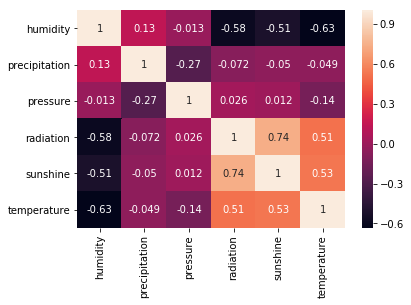

In [156]:
sns.heatmap(df_res.corr(),annot=True)

/home/abhay/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/abhay/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


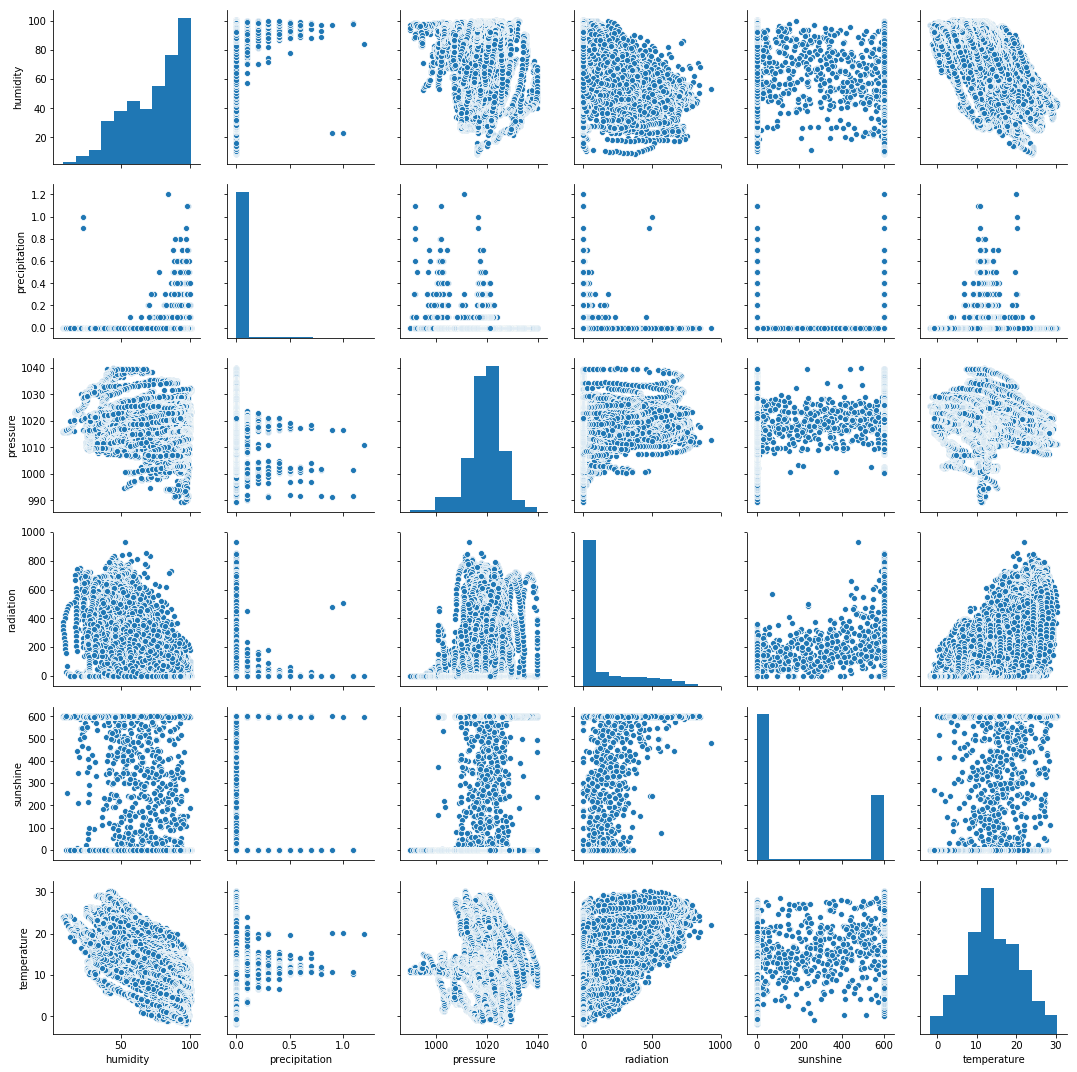

In [157]:
sns.pairplot(df_res)

In [158]:
temp_mean = df_res["temperature"].mean()
temp_std = df_res["temperature"].std()
df_res["mean"] = temp_mean
df_res["upper_limit"] = temp_mean + (temp_std * 3)
df_res["lower_limit"] = temp_mean - (temp_std * 3)
print(df_res.iloc[0]["upper_limit"])
print(df_res.iloc[0]["mean"])
print(df_res.iloc[0]["lower_limit"])

33.90644312823735
14.067669806263815
-5.771103515709719


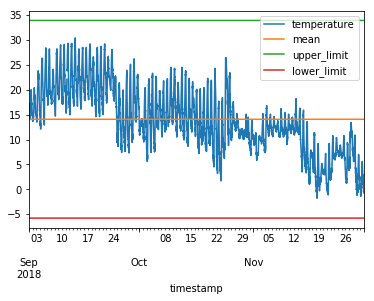

In [159]:
df_res[['temperature','mean','upper_limit','lower_limit']].plot()
plt.show()

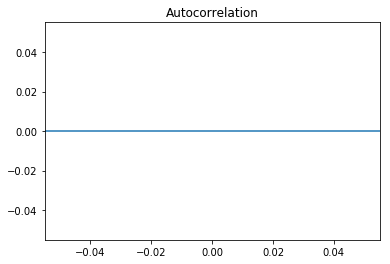

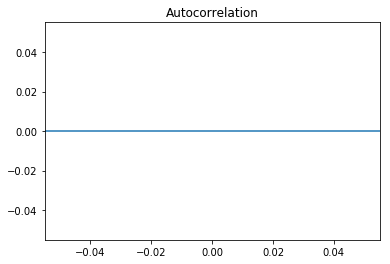

In [160]:
tsaplots.plot_acf(env['temperature'])

In [161]:
split_day = "2018-10-13"
train = df_res[:split_day]
test = df_res[split_day:]
print(train.iloc[0].name)
print(train.iloc[-1].name)
print(test.iloc[0].name)
print(test.iloc[-1].name)

2018-09-01 00:00:00
2018-10-13 23:50:00
2018-10-13 00:00:00
2018-11-30 23:00:00


In [147]:
X_train = train.drop("target", axis=1)
y_train = train["target"]
X_test = test.drop("target", axis=1)
y_test = test["target"]
print(X_train.shape)
print(y_train.shape)

In [ ]:
# Initialize Objects
sc = StandardScaler()
logreg = LogisticRegression()
# Create pipeline
pl = Pipeline([
("scale", sc),
("logreg", logreg)
])

pl.fit(X_train, y_train)

In [ ]:
with Path("pipeline_model.pkl").open("bw") as f:
    pickle.dump(pl, f)

In [ ]:
with Path("pipeline_model.pkl").open('br') as f:
    pl = pickle.load(f)
    
print(pl.predict(X_test))
print(pl.score(X_test, y_test))

In [ ]:
# # Uncomment below code if wants to process data into a continous stream

# cache = []
# def on_message(client, userdata, message):
#     data = json.loads(message.payload)
#     cache.append(data)
#     if len(cache) > MAX_CACHE:
#         with Path("data.txt").open("a") as f:
#             f.writelines(cache)
#         cache.clear()
#         df = pd.DataFrame.from_records([data],
#         index="timestamp",
#         columns=cols)
#         category = pl.predict(df)
#         maybe_alert(category[0])
    
# subscribe.callback(on_message,topics="toppics_name",hostname="hostName")